Some basic statistics and visualisations of the data

First some technical initialisations:

In [1]:
!conda update -y dask

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - dask


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.10.16 |                0         131 KB
    dask-core-2.6.0            |             py_0         578 KB
    openssl-1.0.2t             |       h7b6447c_1         3.1 MB
    dask-2.6.0                 |             py_0          12 KB
    certifi-2019.9.11          |           py36_0         154 KB
    partd-1.0.0                |             py_0          19 KB
    distributed-2.6.0          |             py_0         393 KB
    ------------------------------------------------------------
    

In [93]:
import pandas as pd
import psycopg2
from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import numpy as np
from scipy.stats import pearsonr
sns.set()
sns.set_style("whitegrid")
%matplotlib inline

In [120]:
client = Client('Dask-Scheduler.local-dask:8786')

In [121]:
client.get_versions(check=False)
client

Client Scheduler: tcp://Dask-Scheduler.local-dask:8786 Dashboard: http://Dask-Scheduler.local-dask:8787/status,Cluster Workers: 2 Cores: 4 Memory: 3.60 GB


In [9]:
def secrets(config_filename='../cnf/sasse_aws.ini', section='production'):
    """ Read secrets from file """
    parser = ConfigParser()    
    parser.read(config_filename)
    secrets = {}    
    if parser.has_section(section):
        params = parser.items(section)
        for param in params:
            secrets[param[0]] = param[1]
    else:
        raise Exception('Section {0} not found in the {1} file'.format(section, config_filename))

    return secrets

In [8]:
secrets = secrets()
db_host = secrets['host']
db_port = secrets['port']
db_name = secrets['database']
db_user = secrets['user']
db_pass = secrets['password']
conf_bucket  ='fmi-sasse-cloudformation'
conf_file    = 'smartmet.yaml'
loiste_bbox  = '25,62.7,31.4,66.4'
sssoy_bbox   = '24.5,60,30.6,63.5'

Loading data:

In [127]:
def get_polygons_over_network(start, end, bbox):
    """ Get polygons from db """

    conn = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s'" % (db_name, db_user, db_host, db_pass))
    
    sql = """
        SELECT weather_parameter,low_limit,high_limit,point_in_time 
        FROM sasse.stormcell 
        WHERE ST_MakeEnvelope({bbox}, 4326) && geom 
         AND point_in_time >= '{start}' AND point_in_time < '{end}'
         """.format(bbox=bbox,start=start,end=end)        

    cursor = conn.cursor()
    cursor.execute(sql)
    results = cursor.fetchall()

    print('Found {} records.'.format(len(results)))

    return results

def get_outages_in_network(start, end, bbox):
    """ Get outages from db """

    conn = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s'" % (db_name, db_user, db_host, db_pass))
    
    sql = """
        SELECT start, st_astext(the_geom) 
        FROM sasse.outages 
        WHERE ST_MakeEnvelope({bbox}, 4326) && the_geom 
         AND start >= '{start}' AND start < '{end}'
         """.format(bbox=bbox,start=start,end=end)        

    cursor = conn.cursor()
    cursor.execute(sql)
    results = cursor.fetchall()

    print('Found {} records.'.format(len(results)))

    return results

In [6]:
polygons_loiste = get_polygons_over_network('2010-01-01', '2019-01-01',loiste_bbox)
polygons_sssoy = get_polygons_over_network('2010-01-01', '2019-01-01',sssoy_bbox)

Found 44857 records.
Found 61116 records.


In [90]:
df = pd.DataFrame(polygons_loiste, columns=['Parameter','Low Limit','High Limit','Time'])
df.sort_values(by=['Time', 'Parameter','Low Limit'], inplace=True)
df.set_index('Time', inplace=True)

In [128]:
outages_loiste = get_outages_in_network('2010-01-01', '2019-01-01',loiste_bbox)
outages_sssoy = get_outages_in_network('2010-01-01', '2019-01-01',sssoy_bbox)

Found 20150 records.
Found 2010 records.


In [149]:
outages_loiste_df = pd.DataFrame(outages_loiste, columns=['Time','Geom'])
outages_loiste_df.sort_values(by=['Time'], inplace=True)
outages_loiste_df.set_index('Time', inplace=True)
outages_loiste_df.index = outages_loiste_df.index.tz_localize(pytz.UTC) # Dates are actually EET but doesn't matter here

# Amount of polygons

Number of polygons over Loiste network

In [11]:
df.groupby(['Parameter', 'Low Limit']).count()

High Limit
Parameter Low Limit            
Pressure  0               25261
WindGust  15              18345
          20               1202
          25                 49

We can see that number of 15 m/s wind gust polygons are distributed quite evenly over time. However, Windgusts over 20 m/s are extremely rare and over 25 m/s gusts we have had only few times during this history. 

Number of pressure polygons is suspiciously high (24 is on storm with 24 time steps). Maybe we should use lower threshold? 

Number of outages do not seem to correlate at all with number of polygons. 

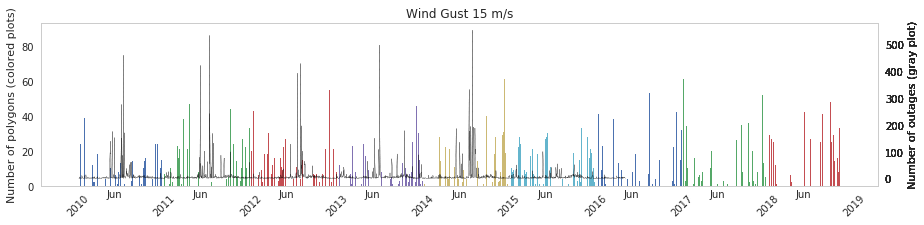

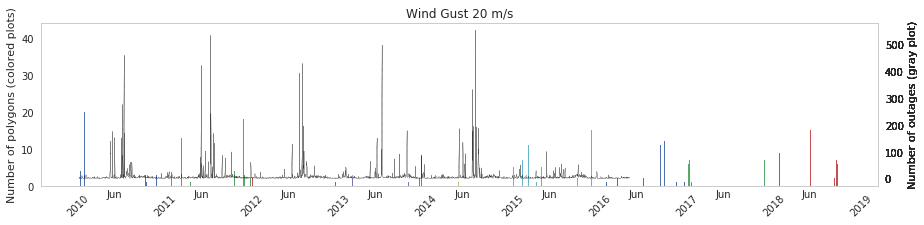

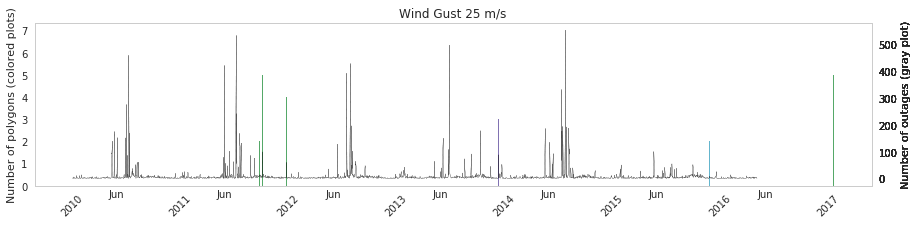

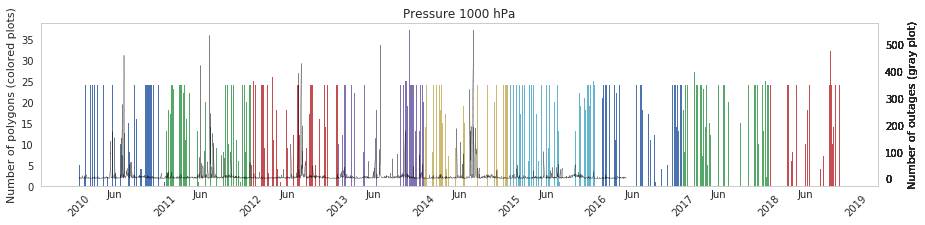

In [188]:
outages = outages_loiste_df.loc[:,'Geom'].groupby(by=[pd.Grouper(freq='D')]).count()
def plot_count(df, title):
    years = range(2010,2019)
    fig, ax = plt.subplots(figsize=(15,3))
    for y in years:
        dfy = df.loc['{}0101'.format(y):'{}1231'.format(y), :]    
        s = dfy.loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count()

        # Outages to background
        ax2 = ax.twinx()
        ax2.plot(outages.index, outages, alpha=0.5, zorder=0, linewidth=0.1, linestyle='dashed', color='black', label='Number of polygons')
        ax2.grid(False)

        # Number of polygons to foreground
        ax.bar(s.index.to_pydatetime(),s.values, zorder=1, label='Number of outages')
        ax.grid(False)
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=6))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))           
        ax.xaxis.set_tick_params(rotation=45)        
        ax.set_ylabel("Number of polygons (colored plots)")
        ax2.set_ylabel("Number of outages (gray plot)")

    plt.grid(False)
    plt.title(title)
    #plt.gcf().autofmt_xdate()
    
plot_count(df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 15)], 'Wind Gust 15 m/s')
plot_count(df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 20)], 'Wind Gust 20 m/s')
plot_count(df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 25)], 'Wind Gust 25 m/s')
plot_count(df[(df.loc[:,'Parameter'] == 'Pressure')], 'Pressure 1000 hPa')

Let's plot some correlation matrices between number of polygons and outages. 

In [225]:
def plot_pval(corr_df, ax):

    coeffmat = np.zeros((corr_df.shape[1], corr_df.shape[1]))
    pvalmat = np.zeros((corr_df.shape[1], corr_df.shape[1]))

    for i in range(corr_df.shape[1]):
        for j in range(corr_df.shape[1]):        
            corrtest = pearsonr(corr_df[corr_df.columns[i]], corr_df[corr_df.columns[j]])  

            coeffmat[i,j] = corrtest[0]
            pvalmat[i,j] = corrtest[1]

    pvalmat_df = pd.DataFrame(pvalmat, columns=corr_df.columns, index=corr_df.columns)
    #fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(pvalmat_df, cmap="YlGnBu", annot=True, ax=ax)
    
def plot_corr(df, odf):
    s = df[(df.loc[:,'Parameter'] == 'Pressure')].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count()
    s2 = df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 15)].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count()
    s3 = df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 20)].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count()
    s4 = df[(df.loc[:,'Parameter'] == 'WindGust') & (df.loc[:,'Low Limit'] == 25)].loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count()
    s5 = odf.loc[:,'Geom'].groupby(by=[pd.Grouper(freq='D')]).count()
    corr_df = pd.concat([s, s2, s3, s4, s5], axis=1, 
                        keys = ['Pressure', 'Wind Gust 15 m/s', 'Wind Gust 20 m/s', 'Wind Gust 25 m/s', 'Nro Outages'])
    corr_df.fillna(0, inplace=True)
    corr = corr_df.corr('pearson')

    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    sns.heatmap(corr, cmap="YlGnBu", annot=True, ax=axes[0])
    axes[0].set_title('Correlation matrix')
    
    plot_pval(corr_df, ax=axes[1])
    axes[1].set_title('P-value test')
    plt.tight_layout()

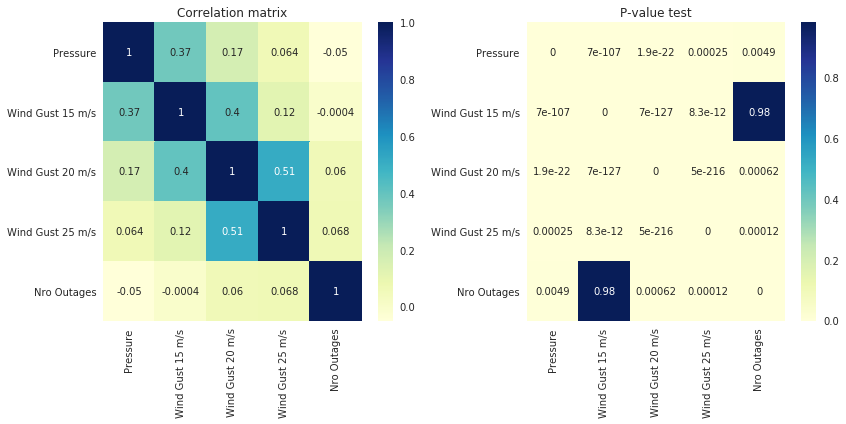

In [226]:
plot_corr(df, outages_loiste_df)

Correlation values are quite low. However, p-value test* indicates that, for wind gust over 20 m/s and pressure polygons, probability that correlation would be falsely interpreted is only under 0.5 %.

*https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/

If we look only winter months, correlation between number of polygons and outages is even more promising.

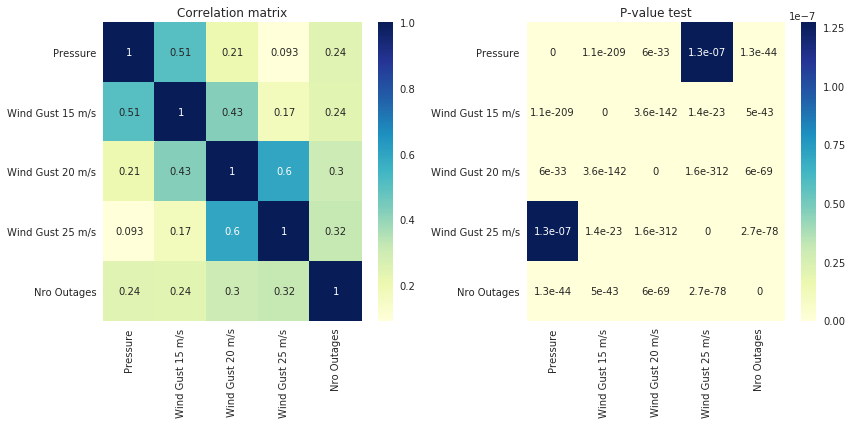

In [227]:
dft = df[(df.index.month >= 10) | (df.index.month <= 1)]
oft = outages_loiste_df[(outages_loiste_df.index.month >= 10) | (outages_loiste_df.index.month <= 1)]
plot_corr(dft, oft)

Dask Index Structure:
npartitions=4
2010-01-03 14:00:00+00:00    datetime64[ns, psycopg2.tz.FixedOffsetTimezone...
2012-02-29 20:00:00+00:00                                                  ...
2014-08-14 05:00:00+00:00                                                  ...
2016-09-28 11:00:00+00:00                                                  ...
2018-10-31 22:00:00+00:00                                                  ...
Name: Time, dtype: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]
Dask Name: getitem, 32 tasks


KilledWorker: ("('from_pandas-ac310789468233adf0a50078202fd5f7', 0)", <Worker 'tcp://172.31.33.91:9000', memory: 0, processing: 1>)

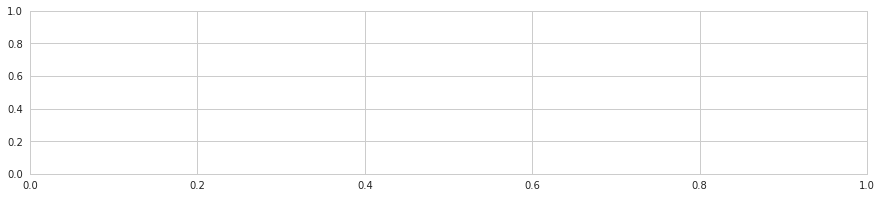

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/client.py", line 1290, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/distributed/utils.py", line 662, in log_errors
  

In [122]:
dfd = dd.from_pandas(df, npartitions=4) 
client.persist(dfd)
import pytz

def plot_count(dfd, title):
    years = range(2010,2019)
    fig, ax = plt.subplots(figsize=(15,3))
    for y in years:
        start = datetime.datetime.strptime('{}0101'.format(y), '%Y%m%d')
        end = datetime.datetime.strptime('{}0131'.format(y), '%Y%m%d')

        start = start.replace(tzinfo=pytz.UTC)
        end = end.replace(tzinfo=pytz.UTC)
            
        #dfy = dfd.loc['{}0101'.format(y):'{}1231'.format(y), :]    
        print(dfd.index)
        dfy = dfd.loc[start:end, :]    
        #s = dfy.loc[:,'Parameter'].groupby(by=[pd.Grouper(freq='D')]).count().compute()
        s = dfy.groupby(by=['Parameter']).count().compute()
        #plt.bar(s.index.to_pydatetime(),s.values)
        progress(dfy)
    
    plt.grid(False)
    plt.title(title)
    plt.gcf().autofmt_xdate()
    
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 15)], 'Wind Gust 15 m/s')
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 20)], 'Wind Gust 20 m/s')
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'WindGust') & (dfd.loc[:,'Low Limit'] == 25)], 'Wind Gust 25 m/s')
plot_count(dfd[(dfd.loc[:,'Parameter'] == 'Pressure')], 'Pressure 1000 hPa')

In [197]:
print(len(df))
print(len(dft))

44857
20785
